In [1]:
import numpy as np
from sklearn.utils import shuffle
import copy
import sys
import os
import _pickle as pickle
import gzip
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
# Loading the CIFAR-10 data
def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding ='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
    return X, Y


def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return (Xtr, Ytr), (Xte, Yte)


In [3]:
def get_im2col_indices(x_shape, field_height=3, field_width=3, padding=1, stride=1):
  # First figure out what the size of the output should be
  N, C, H, W = x_shape
  assert (H + 2 * padding - field_height) % stride == 0
  assert (W + 2 * padding - field_height) % stride == 0
  out_height = (H + 2 * padding - field_height) / stride + 1
  out_width = (W + 2 * padding - field_width) / stride + 1

  i0 = np.repeat(np.arange(field_height,dtype='int32'), field_width)
  i0 = np.tile(i0, C)
  i1 = stride * np.repeat(np.arange(out_height,dtype='int32'), out_width)
  j0 = np.tile(np.arange(field_width), field_height * C)
  j1 = stride * np.tile(np.arange(out_width,dtype='int32'), int(out_height))
  i = i0.reshape(-1, 1) + i1.reshape(1, -1)
  j = j0.reshape(-1, 1) + j1.reshape(1, -1)

  k = np.repeat(np.arange(C,dtype='int32'), field_height * field_width).reshape(-1, 1)

  return (k, i, j)

def im2col_indices(x, field_height=3, field_width=3, padding=1, stride=1):
  # Zero-pad the input
  p = padding
  x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

  k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                               stride)

  cols = x_padded[:, k, i, j]
  C = x.shape[1]
  cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
  return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
  N, C, H, W = x_shape
  H_padded, W_padded = H + 2 * padding, W + 2 * padding
  x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
  k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                               stride)
  cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
  cols_reshaped = cols_reshaped.transpose(2, 0, 1)
  np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
  if padding == 0:
    return x_padded
  return x_padded[:, :, padding:-padding, padding:-padding]

pass

In [4]:
class Conv():

    def __init__(self, X_dim, n_filter, h_filter, w_filter, stride, padding):

        self.d_X, self.h_X, self.w_X = X_dim

        self.n_filter, self.h_filter, self.w_filter = n_filter, h_filter, w_filter
        self.stride, self.padding = stride, padding

        self.W = np.random.randn(n_filter, self.d_X, h_filter, w_filter) / np.sqrt(n_filter / 2.)
        self.b = np.zeros((self.n_filter, 1))
        self.params = [self.W, self.b]

        self.h_out = (self.h_X - h_filter + 2 * padding) / stride + 1
        self.w_out = (self.w_X - w_filter + 2 * padding) / stride + 1

        self.h_out, self.w_out = int(self.h_out), int(self.w_out)
        self.out_dim = (self.n_filter, self.h_out, self.w_out)

    def forward(self, X):

        self.n_X = X.shape[0]

        self.X_col = im2col_indices(
            X, self.h_filter, self.w_filter, stride=self.stride, padding=self.padding)
        W_row = self.W.reshape(self.n_filter, -1)

        out = W_row @ self.X_col + self.b
        out = out.reshape(self.n_filter, self.h_out, self.w_out, self.n_X)
        out = out.transpose(3, 0, 1, 2)
        return out

    def backward(self, dout):

        dout_flat = dout.transpose(1, 2, 3, 0).reshape(self.n_filter, -1)

        dW = dout_flat @ self.X_col.T
        dW = dW.reshape(self.W.shape)

        db = np.sum(dout, axis=(0, 2, 3)).reshape(self.n_filter, -1)

        W_flat = self.W.reshape(self.n_filter, -1)

        dX_col = W_flat.T @ dout_flat
        shape = (self.n_X, self.d_X, self.h_X, self.w_X)
        dX = col2im_indices(dX_col, shape, self.h_filter,
                            self.w_filter, self.padding, self.stride)

        return dX, [dW, db]


class Maxpool():

    def __init__(self, X_dim, size, stride):

        self.d_X, self.h_X, self.w_X = X_dim

        self.params = []

        self.size = size
        self.stride = stride

        self.h_out = (self.h_X - size) / stride + 1
        self.w_out = (self.w_X - size) / stride + 1
        self.h_out, self.w_out = int(self.h_out), int(self.w_out)
        self.out_dim = (self.d_X, self.h_out, self.w_out)

    def forward(self, X):
        self.n_X = X.shape[0]
        X_reshaped = X.reshape(
            X.shape[0] * X.shape[1], 1, X.shape[2], X.shape[3])

        self.X_col = im2col_indices(
            X_reshaped, self.size, self.size, padding=0, stride=self.stride)

        self.max_indexes = np.argmax(self.X_col, axis=0)
        out = self.X_col[self.max_indexes, range(self.max_indexes.size)]

        out = out.reshape(self.h_out, self.w_out, self.n_X,
                          self.d_X).transpose(2, 3, 0, 1)
        return out

    def backward(self, dout):

        dX_col = np.zeros_like(self.X_col)
        # flatten the gradient
        dout_flat = dout.transpose(2, 3, 0, 1).ravel()

        dX_col[self.max_indexes, range(self.max_indexes.size)] = dout_flat

        # get the original X_reshaped structure from col2im
        shape = (self.n_X * self.d_X, 1, self.h_X, self.w_X)
        dX = col2im_indices(dX_col, shape, self.size,
                            self.size, padding=0, stride=self.stride)
        dX = dX.reshape(self.n_X, self.d_X, self.h_X, self.w_X)
        return dX, []


class Flatten():

    def __init__(self):
        self.params = []

    def forward(self, X):
        self.X_shape = X.shape
        self.out_shape = (self.X_shape[0], -1)
        out = X.ravel().reshape(self.out_shape)
        self.out_shape = self.out_shape[1]
        return out

    def backward(self, dout):
        out = dout.reshape(self.X_shape)
        return out, ()


class FullyConnected():

    def __init__(self, in_size, out_size):

        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size / 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]

    def forward(self, X):
        self.X = X
        out = self.X @ self.W + self.b
        return out

    def backward(self, dout):
        dW = self.X.T @ dout
        db = np.sum(dout, axis=0)
        dX = dout @ self.W.T
        return dX, [dW, db]



class ReLU():
    def __init__(self):
        self.params = []

    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dout):
        dX = dout.copy()
        dX[self.X <= 0] = 0
        return dX, []


class sigmoid():

    def forward(self, X):
        out = 1.0 / (1.0 + np.exp(X))
        self.out = out
        return out

    def backward(self, dout):
        dX = dout * self.out * (1 - self.out)
        return dX, []



In [5]:
def l2_regularization(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss

def delta_l2_regularization(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads

def SoftmaxLoss(X, y):
    m = y.shape[0]
    p = softmax(X)
    log_likelihood = -np.log(p[range(m), y])
    loss = np.sum(log_likelihood) / m

    dx = p.copy()
    dx[range(m), y] -= 1
    dx /= m
    return loss, dx

In [6]:
class CNN:

    def __init__(self, layers, loss_func=SoftmaxLoss):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.append(layer.params)
        self.loss_func = loss_func

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dout):
        grads = []
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout)
            grads.append(grad)
        return grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss, dout = self.loss_func(out, y)
        loss += l2_regularization(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_regularization(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)



In [7]:
def create_batches(X, y, size,shuffles=True):
    m = X.shape[0]
    batches = []
    if shuffles:
        X, y = shuffle(X, y)
    for i in range(0, m, size):
        X_batch = X[i:i + size, :, :, :]
        y_batch = y[i:i + size, ]
        batches.append((X_batch, y_batch))
    return batches


def update(params, grads, learning_rate=0.01):
    for param, grad in zip(params, reversed(grads)):
        for i in range(len(grad)):
            param[i] += - learning_rate * grad[i]


def sgd(nnet, X_train, y_train, size, epoch, learning_rate, verbose=True,X_test=None, y_test=None):
    batches = create_batches(X_train, y_train, size)
    tr_acc = []
    tt_acc = []
    L = []
    print("---------------------------------------------");
    for i in range(epoch):
        loss = 0
        if verbose:
            print("Epoch {0}".format(i + 1))
        for X_batch, y_batch in batches:
            loss, grads = nnet.train_step(X_batch, y_batch)
            update(nnet.params, grads, learning_rate=learning_rate)
        if verbose:
            train_acc = accuracy(y_train, nnet.predict(X_train))
            test_acc = accuracy(y_test, nnet.predict(X_test))
            print("Loss = {0} ".format(loss))
            print("Training Accuracy = {0}".format(train_acc));
            print("Test Accuracy = {0}".format(test_acc));
            print("---------------------------------------------");
            tr_acc.append(train_acc)
            tt_acc.append(test_acc)
            L.append(loss)
    return nnet, L, tr_acc, tt_acc




In [8]:
def one_hot_encode(y, num_class):
    m = y.shape[0]
    onehot = np.zeros((m, num_class), dtype="int32")
    for i in range(m):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def accuracy_plot(train_data_acc, test_data_acc):
    plt.plot(train_data_acc, 'r--', label = 'Training Accuracy')
    plt.plot(test_data_acc, 'b--', label = 'Test Accuracy')
    plt.title("(CIFAR-10) Accuracy vs Epoch (Learning rate = 0.01)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper left')
    plt.show()

def loss_plot(loss):
    plt.plot(loss, 'b--')
    plt.title("(CIFAR-10) Loss vs Epoch (Learning rate = 0.01)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [9]:
def make_cifar10_cnn(X_dim, num_class):
    conv = Conv(X_dim, n_filter=16, h_filter=7,
                w_filter=7, stride=1, padding=3)
    relu = ReLU()
    maxpool = Maxpool(conv.out_dim, size=2, stride=2)
    conv2 = Conv(maxpool.out_dim, n_filter=20, h_filter=7,
                 w_filter=7, stride=1, padding=3)
    relu2 = ReLU()
    maxpool2 = Maxpool(conv2.out_dim, size=2, stride=2)
    flat = Flatten()
    fc = FullyConnected(np.prod(maxpool2.out_dim), num_class)
    return [conv, relu, maxpool, conv2, relu2, maxpool2, flat, fc]



---------------------------------------------
Epoch 1
Loss = 2.931502448518231 
Training Accuracy = 0.2548
Test Accuracy = 0.23
---------------------------------------------
Epoch 2
Loss = 2.88244443044099 
Training Accuracy = 0.314
Test Accuracy = 0.27
---------------------------------------------
Epoch 3
Loss = 2.9330007622067793 
Training Accuracy = 0.3564
Test Accuracy = 0.285
---------------------------------------------
Epoch 4
Loss = 2.951902842816294 
Training Accuracy = 0.3832
Test Accuracy = 0.3
---------------------------------------------
Epoch 5
Loss = 2.9750892727288942 
Training Accuracy = 0.4256
Test Accuracy = 0.325
---------------------------------------------
Epoch 6
Loss = 2.919995230190565 
Training Accuracy = 0.4608
Test Accuracy = 0.34
---------------------------------------------
Epoch 7
Loss = 2.8955817457904205 
Training Accuracy = 0.488
Test Accuracy = 0.34
---------------------------------------------
Epoch 8
Loss = 2.8148285009719887 
Training Accuracy = 0.

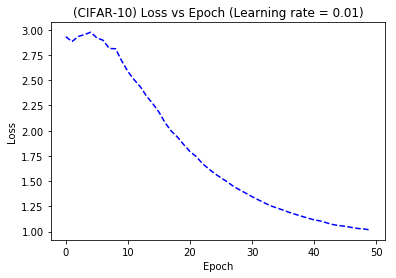

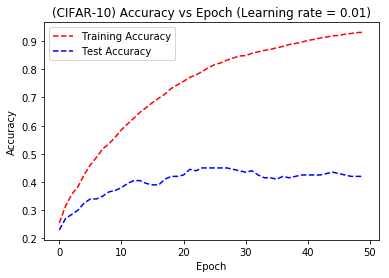

In [ ]:
training_set, test_set = load(r'/Users/shivangi/Downloads/ShivangiGupta_Homework2/cifar-10-batches-py')

#Running the Convolution Network on 5% of the CIFAR-10 data.
X, y = training_set
X_test, y_test = test_set
X_train = X[:2500] / 255.
y_train = y[:2500].astype(int)
X_test = X_test[:200] / 255.
y_test = y_test[:200].astype(int)


cifar10_dims = (3, 32, 32)
cnn = CNN(make_cifar10_cnn(cifar10_dims, num_class=10))
cnn, Loss, train, test  = sgd(cnn, X_train, y_train, size=20, epoch=50,learning_rate=0.01, X_test=X_test, y_test=y_test)

loss_plot(Loss)
accuracy_plot(train,test)

In [ ]:
#Running the Convolution Network on the full CIFAR-10 data.
X, y = training_set
X_test, y_test = test_set
X_train = X / 255.
y_train = y.astype(int)
X_test = X_test / 255.
y_test = y_test.astype(int)


cifar10_dims = (3, 32, 32)
cnn = CNN(make_cifar10_cnn(cifar10_dims, num_class=10))
cnn, Loss, train, test  = sgd(cnn, X_train, y_train, size=20, epoch=100,learning_rate=0.01, X_test=X_test, y_test=y_test)

loss_plot(Loss)
accuracy_plot(train,test)

---------------------------------------------
Epoch 1


/Users/shivangi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
